In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
from google.colab.patches import cv2_imshow as imshow

In [2]:
#create a folder to store data
!mkdir sample_data/IAM
!mkdir sample_data/IAM/words
# copy the zip files that has data to this folder now
!cp -nav "/content/drive/My Drive/IAM word/words.tgz" "/content/sample_data/IAM"

'/content/drive/My Drive/IAM word/words.tgz' -> '/content/sample_data/IAM/words.tgz'


In [ ]:
# now unzip all the zips
!tar -xzvf "/content/sample_data/IAM/words.tgz" -C "/content/sample_data/IAM/words/"

In [4]:
# copy the ground truth texts file
!cp -navr "/content/drive/My Drive/IAM word/words.txt" "/content/sample_data/IAM/"

'/content/drive/My Drive/IAM word/words.txt' -> '/content/sample_data/IAM/words.txt'


In [5]:
data_location = '/content/sample_data/IAM/words'
words_txt_location = '/content/sample_data/IAM/words.txt'

In [6]:
!cp -navr "/content/drive/My Drive/IAM word/train_files.txt" "/content/sample_data/IAM/"
!cp -navr "/content/drive/My Drive/IAM word/valid_files.txt" "/content/sample_data/IAM/"

'/content/drive/My Drive/IAM word/train_files.txt' -> '/content/sample_data/IAM/train_files.txt'
'/content/drive/My Drive/IAM word/valid_files.txt' -> '/content/sample_data/IAM/valid_files.txt'


In [7]:
def get_paths_and_gts(partition_split_file):

  paths_and_gts = []  
  with open(partition_split_file) as f:
    f=f.readlines()

    for i in range(0,len(f),10):
      line=f[i]
      if not line or line.startswith('#'):
                continue
            
      # in the text file, each line is seperated with '\n', so `strip` first
      # then string like 'a01-000u-00-00 ok 154 408 768 27 51 AT A' has to split to a list by spaces
      line_split = line.strip().split(' ')
      
      # the first item of the list contains path information, so split that by '-'
      directory_split = line_split[0].split('-')
      
      # now use all the above and concatenate to a string to make a path to an image
      image_location = f'{data_location}/{directory_split[0]}/{directory_split[0]}-{directory_split[1]}/{line_split[0]}.png'
      
      # in a string like 'a01-000u-00-00 ok 154 408 768 27 51 AT A', text from 9th split is the ground truth text.
      gt_text = ' '.join(line_split[8:])
      
      # ignore a sample(image and ground truth text), if the ground truth has more than 16 letters
      if len(gt_text) > 16:
          continue
      
      # now, append the image location and ground truth text of that image as a list to 
      paths_and_gts.append([image_location, gt_text])
    
    return paths_and_gts

In [8]:
def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    #img_pad = np.zeros([new_h, new_w, 3]) 
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2, :] = img
    return img_pad

def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w < target_w and h < target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_w = target_w
        new_h = int(h * new_w / w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_h = target_h
        new_w = int(w * new_h / h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        """w>=target_w and h>=target_h """
        ratio = max(w / target_w, h / target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img


def preprocess(path, img_w, img_h):
    """ Pre-processing image for predicting """
    img = cv2.imread(path)
    img = fix_size(img, img_w, img_h)

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = img.astype(np.float32)
    img /= 255
    return img

In [9]:
letters = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
           '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?',
           'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
           'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

num_classes = len(letters) + 1
print(num_classes)

80


In [10]:
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

In [17]:
train_files = get_paths_and_gts('/content/sample_data/IAM/train_files.txt')
len(train_files)

8730

In [18]:
valid_files = get_paths_and_gts('/content/sample_data/IAM/valid_files.txt')

better


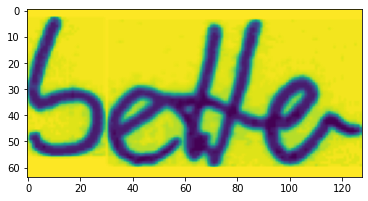

In [37]:
#testing

i = 56
print(train_files[i][1])
img=preprocess(path=train_files[i][0], img_w=128, img_h=64)
plt.imshow(img)

In [21]:
class TextImageGenerator:
    
    def __init__(self, data,
                 img_w,
                 img_h, 
                 batch_size, 
                 i_len,
                 max_text_len):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.samples = data
        self.n = len(self.samples)
        self.i_len = i_len
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = preprocess(img_filepath, self.img_w, self.img_h)
            self.imgs[i, :, :] = img
            self.texts.append(text)
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * self.i_len
            label_length = np.zeros((self.batch_size, 1))

            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i, :len(text)] = text_to_labels(text)
                label_length[i] = len(text)
                
            inputs = [X_data, Y_data, input_length, label_length]
            outputs = np.zeros([self.batch_size])
            yield (inputs, outputs)

In [22]:
batch_size = 64
input_length = 30
max_text_len = 16
img_w = 128
img_h = 64

In [23]:
train_data = TextImageGenerator(train_files, img_w, img_h, batch_size, input_length, max_text_len)
train_data.build_data()

In [24]:
validation_data = TextImageGenerator(valid_files, img_w, img_h, batch_size, input_length, max_text_len)
validation_data.build_data()

In [25]:
train_data.imgs.shape

(8730, 64, 128)

# Creating Model

In [26]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [ ]:
input_data = layers.Input(name='the_input', shape=(128,64,1), dtype='float32')  # (None, 128, 64, 1)

# Convolution layer (VGG)
iam_layers = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max1')(iam_layers)  # (None,64, 32, 64)

iam_layers = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max2')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max3')(iam_layers)  # (None, 32, 8, 256)

iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv6')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max4')(iam_layers)

iam_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)

# CNN to RNN
iam_layers = layers.Reshape(target_shape=((32, 2048)), name='reshape')(iam_layers)
iam_layers = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(iam_layers)

# RNN layer
# layer ten
iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)
# layer nine
iam_layers = layers.Bidirectional(layers.LSTM(units=256, return_sequences=True))(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)

# transforms RNN output to character activations:
iam_layers = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(iam_layers)
iam_outputs = layers.Activation('softmax', name='softmax')(iam_layers)

labels = layers.Input(name='the_labels', shape=[16], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return tf_keras_backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


# loss function
loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([iam_outputs, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.summary()

In [28]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

In [29]:
import time
from tensorflow.keras.callbacks import Callback

class EpochTimeHistory(Callback):
    """
    a custom callback to print the time(in minutes, to console) each epoch took during.
    """
    def on_train_begin(self, logs={}):
        self.train_epoch_times = []
        self.valid_epoch_times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)
        self.train_epoch_times.append(cur_epoch_time)
        print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))


    def on_test_begin(self, logs={}):
        self.test_time_start = time.time()

    def on_test_end(self, logs={}):
        cur_test_time = round((time.time() - self.test_time_start)/60, 4)
        self.valid_epoch_times.append(cur_test_time)
        print(" ;validation took {} minutes.".format(cur_test_time))

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_save_cb = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/OCR on IAM/data/two-weights-epoch{epoch:02d}-val_loss{val_loss:.3f}.h5',
                                verbose=1, save_best_only=False, monitor='val_loss', save_weights_only=False)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min')
# reduce_learning_rate_cb = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.00001, verbose=1)
epoch_times = EpochTimeHistory()

In [31]:
batch_size, train_data.n, validation_data.n

(64, 8730, 432)

In [ ]:
history_model_3 = model.fit(train_data.next_batch(),
                            validation_data=validation_data.next_batch(),
                            steps_per_epoch=train_data.n/batch_size,
                            validation_steps=validation_data.n // batch_size,
                            epochs=3,
                            callbacks=[earlystop, model_save_cb, epoch_times])

# Testing model

In [ ]:
iam_model_pred = None
iam_model_pred = Model(inputs=input_data, outputs=iam_outputs)
iam_model_pred.summary()

In [82]:
iam_model_pred.load_weights(filepath='/content/drive/My Drive/Colab Notebooks/OCR on IAM/data/lstm-weights-epoch24-val_loss0.242.h5')

In [83]:
i=76
test_image_processed = preprocess(path=train_files[i][0], img_w=128, img_h=64)
test_image_processed=test_image_processed.T

test_image_processed=[test_image_processed]
test_image_processed = np.array(test_image_processed)

n=test_image_processed.shape[0]
n

1

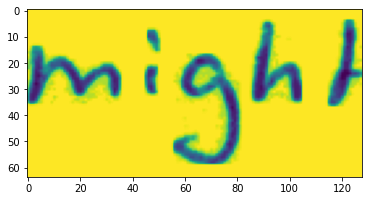

In [84]:
plt.imshow(preprocess(path=train_files[i][0], img_w=128, img_h=64))

In [85]:
test_image_processed = test_image_processed.reshape(n, 128, 64, 1)
test_image_processed.shape

(1, 128, 64, 1)

In [86]:
test_predictions_encoded = iam_model_pred.predict(x=test_image_processed)
test_predictions_encoded.shape

(1, 32, 80)

In [87]:
test_predictions_decoded = tf_keras_backend.get_value(tf_keras_backend.ctc_decode(test_predictions_encoded,
                                                                                  input_length = np.ones(test_predictions_encoded.shape[0])*test_predictions_encoded.shape[1],
                                                                                  greedy=True)[0][0])
test_predictions_decoded.shape

(1, 32)

In [89]:
def numbered_array_to_text(numbered_array):
    numbered_array = numbered_array[numbered_array != -1]
    return "".join(letters[j] for j in numbered_array)

In [88]:
print(test_predictions_decoded)

[[21 65 61 59 60 72 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1]]


In [90]:
numbered_array_to_text(test_predictions_decoded[0])

'7might'